In [98]:
import random
import sys, os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import fitstools
from pathlib import PurePath
import glob
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from balltracking import mballtrack as mblt
from skimage.feature import blob_log, blob_dog, peak_local_max
from matplotlib.patches import Ellipse


plt.rcParams.update({'font.size': 12})
dpi = 168
DTYPE = np.float32

DSUN_OBS= 1.433675e6 # km
DT = 5*60 # 5 minutes time interval between each frame
CDELT2  = 0.0141875720451562 # solar radius / px
VUNIT = CDELT2 * (DSUN_OBS/2)/DT 

In [95]:
def prep_data(image):
    image2 = np.abs(image)
    image3 = image2.max() - image2
    surface = (image3 - image3.mean())/image3.std()
    return surface.copy(order='C').astype(DTYPE)

def add_colorbar(axes, image_object, title=''):
    # position for the colorbar
    divider = make_axes_locatable(axs)
    cax = divider.append_axes('right', size='1%', pad=0.3)
    # Adding the colorbar
    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.set_ylabel('Data surface depth')
    return cbar

In [60]:
# Data prepped by COR2_tracking_prep.ipynb
datadir = PurePath(os.environ['DATA'], 'STEREO/L7tum/prep_fits')
outputdir = PurePath(os.environ['DATA'], 'STEREO/L7tum/')
datafiles = sorted(glob.glob(str(PurePath(datadir, '*.fits'))))
nfiles = len(datafiles)
nsamples = 10

image = fitstools.fitsread(datafiles[0], cube=False)
blob_thresh = 1.0
overlap = 0.6

surface_inv = -prep_data(image)
blobs_dog = blob_dog(surface_inv, overlap=overlap, threshold=blob_thresh, min_sigma=[6, 2], max_sigma=[20, 10])

init_pos = np.fliplr(blobs_dog[:, 0:2]).T

mbt_dict = {"nt": nsamples,
            "rs": 4,
            "am": 1,
            "dp": 0.3,
            "tdx": 1,
            "tdy": 100,
            "zdamping": 1,
            "ballspacing": 15,
            "intsteps": 20,
            "mag_thresh": 3.5,
            "noise_level": 2,
            "track_emergence": False,
            "prep_function": prep_data,
            "datafiles": datafiles,
            "init_pos": init_pos,
            "do_plots": False,
            "astropy": True,
            "verbose": False,
            "outputdir": datadir,
            "fig_dir": PurePath(datadir, 'figures')}

In [4]:
mbt = mblt.MBT(polarity=1, **mbt_dict)

nballs_max = 1552


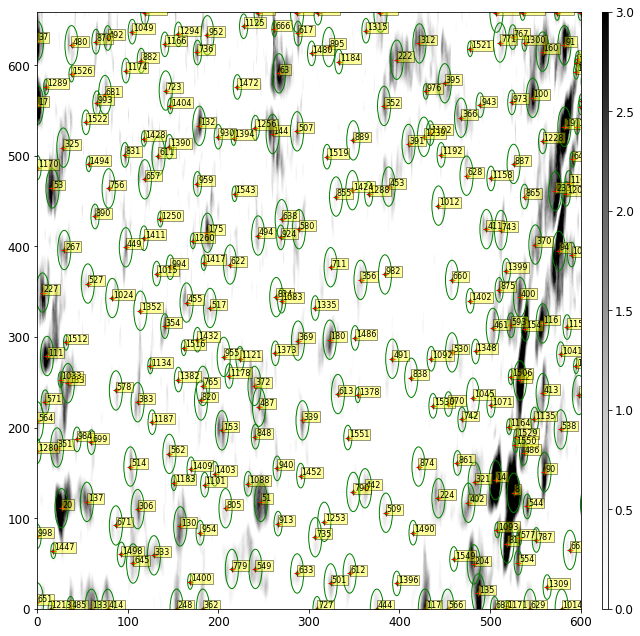

In [87]:
n = 0
# Load the image at the current time index
image = fitstools.fitsread(datafiles[n], cube=False)
surface_inv = -prep_data(image)
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(10, 9))
im = axs.imshow(surface_inv, vmin=0, vmax=3, origin='lower', cmap='Greys')
cbar = add_colorbar(axs, im)

for b, blob in enumerate(blobs_dog):
    blob_label = str(b)
    y, x, sigma_rows, sigma_cols = blob
    ry = sigma_rows * np.sqrt(2) * 2
    rx = sigma_cols * np.sqrt(2) * 2
    ell = Ellipse((x, y), rx, ry, linewidth=1, fill=False, color='green', linestyle='-')
    axs.add_artist(ell)
    axs.plot(x, y, 'g.')
    axs.text(x+1, y+1, blob_label, color='black', fontsize=8,
             bbox=dict(facecolor='yellow', alpha=0.4, edgecolor='black', pad=1), clip_on=True)

if n == 0:
    axs.plot(mbt.xstart, mbt.ystart, 'r+')


axs.set_xlim([0, 600])
axs.set_ylim([0, 659])

plt.tight_layout()

Have a look at the local peaks within each ellipse: 
Must get the points satisfying (x - xc)^2/a^2 + (y - yc)^2/b^2 < 1 with (xc, yc) center of ellipse, a, b semi-major and semi-minor axis. 

In [126]:
def make_ell_points(xc, yc, rx, ry, imshape):
    
    ellgridx = np.arange(xc - rx, xc + rx + 1, dtype=np.int32)
    ellgridy = np.arange(yc - ry, yc + ry + 1, dtype=np.int32)
    xx, yy = np.meshgrid(ellgridx, ellgridy)
    ell_x = []
    ell_y = []
    for x, y in zip(xx.ravel(), yy.ravel()):
        if x > 0 and y > 0 and x < imshape[1] and y < imshape[0] and (x - xc)**2/a**2 + (y - yc)**2/b**2 <= 1:
            ell_x.append(x)
            ell_y.append(y)
            
    return ell_x, ell_y

In [66]:
a = 5
b = 10
xc, yc = 15, 20

ell_x, ell_y = make_ell_points(xc, yc, a, b, image.shape)
mask = np.zeros([40, 40])
mask[ell_y, ell_x] = 1

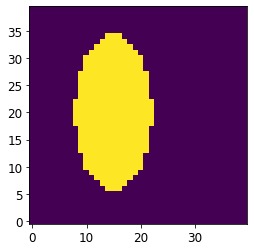

In [67]:
plt.figure()
plt.imshow(mask, origin='lower')

In [68]:
label_mask = np.zeros(image.shape, dtype=np.int64)
for i, blob in enumerate(blobs_dog):
    yc, xc, b, a = blob
    ell_x, ell_y = make_ell_points(xc, yc, a*np.sqrt(2), b*np.sqrt(2), image.shape)
    label_mask[ell_y, ell_x] = i+1

In [69]:
peaks = peak_local_max(surface_inv, labels=label_mask, num_peaks_per_label=1)
peaks.shape, blobs_dog.shape

((1551, 2), (1552, 4))

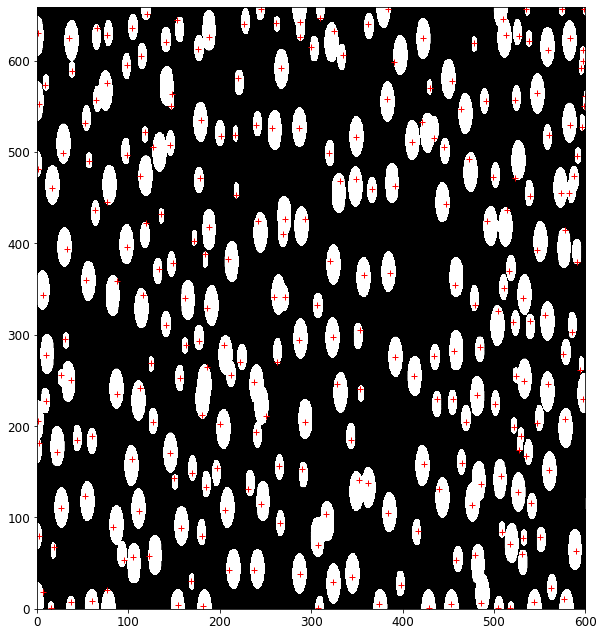

In [70]:
plt.figure(figsize=(10,9))
plt.imshow(label_mask, origin='lower', vmin=0, vmax=1, cmap='gray')
plt.plot(peaks[:,1], peaks[:,0], 'r+')
plt.xlim([0, 600])
plt.ylim([0, 659])

plt.tight_layout()

Keep only the peaks that are within a reasonnable distance from the edges of the ellipses

In [16]:
label_mask = np.zeros(image.shape, dtype=np.int64)
yc, xc, b, a = blobs_dog[0]
ell_x, ell_y = make_ell_points(xc, yc, a, b, image.shape)
label_mask[ell_y, ell_x] = 1
peak = peak_local_max(surface_inv, labels=label_mask, num_peaks_per_label=1)
peak

array([[ 308, 3125]])

In [131]:
peaks_time_series = []

overlap = 0.6
for n in range(0, 10):
    print('Frame n= ', n)
    # n = 0
    # Load the image at the current time index
    image = fitstools.fitsread(datafiles[n], cube=False)
    surface_inv = -prep_data(image)
    blobs_dog = blob_dog(surface_inv, overlap=overlap, threshold=blob_thresh, min_sigma=[5, 1], max_sigma=[20, 10])

    plt.close('all')
    fig, axs = plt.subplots(figsize=(16,14))
    im = axs.imshow(surface_inv, vmin=0, vmax=3, origin='lower', cmap='Greys')
    axs.set_xlim([0, 600])
    axs.set_ylim([0, 659])
    axs.set_xlabel('Azimuth [px] - 1px = 0.1 deg')
    axs.set_ylabel('Radial distance [px]')
    cbar = add_colorbar(axs, im)
    plt.tight_layout()

    peaks = []
    for i, blob in enumerate(blobs_dog):
        yc, xc, b, a = blob
        ry = b * np.sqrt(2)
        rx = a * np.sqrt(2)
        ell = Ellipse((xc, yc), rx*2, ry*2, linewidth=1, fill=False, color='green', linestyle='-')
        axs.add_artist(ell)
        ell_x, ell_y = make_ell_points(xc, yc, rx, ry, image.shape)
        label_mask = np.zeros(image.shape, dtype=np.int64)
        label_mask[ell_y, ell_x] = 1
        peak = peak_local_max(surface_inv, labels=label_mask, num_peaks_per_label=1)

        # Only consider if close enough from the geometric center of the ellipse
        if len(peak) > 0:
            peaks.append(peak[0])
            ypeak, xpeak = peak[0]
            axs.plot(xpeak, ypeak, 'r+')
            # print(i, xc, yc, a, b)
            ry = b * np.sqrt(2)
            rx = a * np.sqrt(2)
            xrel = abs(peak[0][1] - xc)/rx
            yrel = abs(peak[0][0] - yc)/ry
            if xrel <= 0.8 and yrel <= 0.5:
                axs.text(xc+1, yc+1, str(i), color='black', fontsize=10,
                 bbox=dict(facecolor='yellow', alpha=0.4, edgecolor='black', pad=1), clip_on=True)
        else:
            peaks.append(np.array([np.NaN, np.NaN]))

    plt.savefig(PurePath(outputdir, 'figures/training_set', f'make_training_frame_{n:03d}.jpg'))
    plt.close()

    peaks = np.array(peaks)
    peaks_time_series.append(peaks)

Frame n=  0
Frame n=  1
Frame n=  2
Frame n=  3
Frame n=  4
Frame n=  5
Frame n=  6
Frame n=  7
Frame n=  8
Frame n=  9


In [ ]:
targets = [
    [21, 27, 32, 42, 59, 100, 185, 358, 643, 1155],
    [52, 70, 92, 97, 93, 75, 66, 56, 55, 53],
    [159, 141, 148, 157, 165, 164, 170, 181, 174],
    [346, 350, 341, 331, 319, 296, 286, 262, 249, 246], 
    [369, 403, 386, 376, 353, 289, 233, 177, 148, 125],
    [409, 385, 361, 336, 320, 292, 269, 247, 228, 224],
    [335, 275, 246, 215, 191, 219, 258, 274, 305, 374
    [9, 10, 9, 10, 13, 23, 29, 38, 62, 108],
    [6, 7, 8, 8, 9, 10, 12, 14, 13, 12], 
    [270, 308, 336, 382, 400, 416, 374, 325, 291, 273],
    [590, 566, 569, 601, 639, 639, 597, 586, 564, 508],
    [127, 115, 116, 112, 113, 105, 101, 115, 131, 155],
    [169, 170, 183, 201, 208, 198, 178, 173, 165, 160],
    
    
]

In [142]:
peaks_time_series[0][169]

array([202., 200.])

In [109]:
peak[0]

array([ 19, 357])

In [110]:
np.array([np.NaN, np.NaN])

array([nan, nan])